In [131]:
#for loading data
import pandas as pd
import json

#for llm
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

#logging
import pickle

#similarity
import regex as re
from sentence_transformers import SentenceTransformer
from scipy.optimize import linear_sum_assignment

#visualization
#plot matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
job_statements = pd.read_excel("datasets/task_statements.xlsx")
job_statements.columns = job_statements.columns.str.lower()
job_statements = job_statements.drop(labels=["incumbents responding","date","domain source"], axis=1).rename(columns={"o*net-soc code":"code", "task type":"type", "task id": "id", "task":"ref_task"})
job_statements = job_statements[~job_statements["type"].str.contains("Supplemental", case=False, na=True)]
job_statements["ind"] = job_statements["code"].str[:2]
job_statements = job_statements.groupby("title").agg({"ref_task":list, "ind": "first"}).reset_index().sort_values("ind")
sampled_occupation = job_statements.groupby('ind', group_keys=False).sample(frac=0.05, random_state=1) #43 samples
sampled_occupation

,title,ref_task,ind
478,Lodging Managers,[Answer inquiries pertaining to hotel policies...,11
777,Spa Managers,"[Respond to customer inquiries or complaints.,...",11
833,Training and Development Managers,[Analyze training needs to develop new trainin...,11
203,Customs Brokers,[Prepare and process import and export documen...,13
386,Government Property Inspectors and Investigators,"[Prepare correspondence, reports of inspection...",13
856,Video Game Designers,[Balance and adjust gameplay experiences to en...,15
559,Nanosystems Engineers,[Provide scientific or technical guidance or e...,17
430,Industrial Engineers,"[Estimate production costs, cost saving method...",17
799,Surveying and Mapping Technicians,"[Position and hold the vertical rods, or targe...",17
170,Conservation Scientists,[Apply principles of specialized fields of sci...,19


In [ ]:
#for trial
trial_df = sampled_occupation.sample(5, random_state= 1)
test_sample_list =[trial_df.iloc[x]["title"] for x in range(5)]

['Customs Brokers',
 'Training and Development Managers',
 'Cooks, Institution and Cafeteria',
 'Painting, Coating, and Decorating Workers',
 'Graphic Designers']

### set up matching function

In [4]:
#get reference description
def get_des (occupation):
    task_list = sampled_occupation.query("title == @occupation")["ref_task"].iloc[0]
    return task_list

In [185]:
def task_gen(occupation,model):
    class task_description(BaseModel):
        count_statements: int
        statements: list[str]


    #initialize model
    model= model

    query = "Generate "+str(len(get_des(occupation)))+" task statements that "+ occupation +" would perform at work."

    prompt_template = ChatPromptTemplate([
        # ("system", "your role is a {name}. Respond like a {name}."),
        ("human","{input}")
        ]
    )
    structured_llm = model.with_structured_output(schema=task_description.model_json_schema())

    prompt = prompt_template.invoke({"occupation": occupation, "input": query})
    response = structured_llm.invoke(prompt)

    return response
    

In [6]:
# parse response
def parse_response(response):
    try:
        parsed = json.loads(response["statements"])
        return parsed
    except:
        try:
            parsed = response["statements"]
            return parsed
        except:
            return np.nan

In [129]:
#pre process text
def preProcessText(text=list):
	processed = []
	for doc in text:
		doc = re.sub(r"\\n", "", doc)
		doc = re.sub(r"\W", " ", doc) #remove non words char
		doc = re.sub(r"\d"," ", doc) #remove digits char
		doc = re.sub(r'\s+[a-z]\s+', " ", doc) # remove a single char
		doc = re.sub(r'^[a-z]\s+', "", doc) #remove a single character at the start of a document
		doc = re.sub(r'\s+', " ", doc)  #replace an extra space with a single space
		doc = re.sub(r'^\s', "", doc) # remove space at the start of a doc
		doc = re.sub(r'\s$', "", doc) # remove space at the end of a document
		processed.append(doc.lower())
	return processed

In [82]:
#get similarity score
def sbert(ref, gen):
    sim_model = SentenceTransformer("all-mpnet-base-v2", similarity_fn_name="cosine")

    # Compute embeddings for both lists
    embeddings_ref = sim_model.encode(ref)
    embeddings_gen = sim_model.encode(gen)


    # Compute cosine similarities
    similarities = sim_model.similarity(embeddings_ref, embeddings_gen).numpy()
    return similarities

In [10]:
#plot graph
def plot(similarities):
    x_label = [x+1 for x in range(len(similarities))]
    y_label = [chr(num + 96) for num in x_label]
    plt.figure(figsize=(12, 12))
    sns.heatmap(similarities, annot=True, fmt=".3f", cmap="crest", xticklabels=x_label, yticklabels=y_label)
    plt.title("Sentence Cosine Similarity for "+ test_occ)
    plt.xlabel("O*NET Data")
    plt.ylabel("Generated Sentence")
    plt.savefig("results/"+test_occ+".png")
    plt.show()
    return plt

In [200]:
def match(ref, gen):
    try:
        ref_clean = preProcessText(ref)
        gen_clean = preProcessText(gen)
        matrix = sbert(ref_clean, gen_clean)
        row_ind, col_ind = linear_sum_assignment(1 - matrix)  # Minimize cost (1 - similarity)
        assigned_similarities = matrix[row_ind, col_ind]
        return np.mean(assigned_similarities), matrix, row_ind.tolist(), col_ind.tolist()
    except:
        return np.nan

### packaging things for repeated excution

In [28]:
model = ChatOllama(model="llama3.1", temperature=0.8)

In [13]:
test_sample_list

['Customs Brokers',
 'Training and Development Managers',
 'Cooks, Institution and Cafeteria',
 'Painting, Coating, and Decorating Workers',
 'Graphic Designers']

In [108]:
for occu in test_sample_list:
    generated_statements = task_gen(occu, model)
    trial_df.loc[trial_df["title"] == occu, "gen_task"] = [generated_statements]

trial_df


,title,ref_task,ind,gen_task,parsed_response
203,Customs Brokers,[Prepare and process import and export documen...,13,"{'count_statements': '21', 'occupation': 'Cust...","[Clearing customs for imported goods, Preparin..."
833,Training and Development Managers,[Analyze training needs to develop new trainin...,11,"{'count_statements': '11', 'occupation': 'Trai...",[Develop and implement training programs for e...
178,"Cooks, Institution and Cafeteria",[Monitor and record food temperatures to ensur...,35,"{'count_statements': '12', 'occupation': '['Co...","[Prepare ingredients for cooking, Cook meals f..."
607,"Painting, Coating, and Decorating Workers","[Apply coatings, such as paint, ink, or lacque...",51,"{'count_statements': '4', 'occupation': 'Paint...",[
388,Graphic Designers,[Key information into computer equipment to cr...,27,"{'count_statements': '17', 'occupation': 'Grap...",[Create visually appealing graphics for social...


In [182]:
result_df = trial_df.reset_index(drop=True)
result_df["parsed_response"] = result_df["gen_task"].apply(parse_response)
result_df = result_df.dropna()
result_df

# result_df

,title,ref_task,ind,gen_task,parsed_response
0,Customs Brokers,[Prepare and process import and export documen...,13,"{'count_statements': '21', 'occupation': 'Cust...","[Clearing customs documents, Preparing shippin..."
1,Training and Development Managers,[Analyze training needs to develop new trainin...,11,"{'count_statements': '11', 'occupation': 'Trai...","[Create training programs for new employees, D..."
2,"Cooks, Institution and Cafeteria",[Monitor and record food temperatures to ensur...,35,"{'count_statements': '12', 'occupation': '['Co...","[Prepares food for customers, Maintains a clea..."
3,"Painting, Coating, and Decorating Workers","[Apply coatings, such as paint, ink, or lacque...",51,"{'count_statements': '4', 'occupation': 'Paint...",[Apply paint or coatings to surfaces using rol...
4,Graphic Designers,[Key information into computer equipment to cr...,27,"{'count_statements': '17', 'occupation': 'Grap...","[Create visual concepts for clients, Develop b..."


In [201]:
result_df[["score", "matrix", "ref_order", "gen_order"]] = result_df.apply(lambda row: match(row["ref_task"], row["parsed_response"]), axis=1).apply(pd.Series)
result_df

,title,ref_task,ind,gen_task,parsed_response,score,ref_order,gen_order,matrix
0,Customs Brokers,[Prepare and process import and export documen...,13,"{'count_statements': '21', 'occupation': 'Cust...","[Clearing customs documents, Preparing shippin...",0.412177,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...","[0, 16, 9, 4, 15, 14, 10, 18, 19, 17, 11, 6, 8...","[[0.694322, 0.5522791, 0.20909467, 0.14723207,..."
1,Training and Development Managers,[Analyze training needs to develop new trainin...,11,"{'count_statements': '11', 'occupation': 'Trai...","[Create training programs for new employees, D...",0.546118,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[10, 4, 7, 3, 0, 6, 1, 8, 2, 5, 9]","[[0.691448, 0.3571793, 0.32961807, 0.23182124,..."
2,"Cooks, Institution and Cafeteria",[Monitor and record food temperatures to ensur...,35,"{'count_statements': '12', 'occupation': '['Co...","[Prepares food for customers, Maintains a clea...",0.423411,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[2, 7, 6, 1, 0, 11, 4, 5, 8, 3, 10, 9]","[[0.4610832, 0.35828227, 0.59520465, 0.1565909..."
3,"Painting, Coating, and Decorating Workers","[Apply coatings, such as paint, ink, or lacque...",51,"{'count_statements': '4', 'occupation': 'Paint...",[Apply paint or coatings to surfaces using rol...,0.511475,"[0, 1, 2, 3]","[0, 2, 3, 1]","[[0.686331, 0.2920332, 0.43539482, 0.38451043]..."
4,Graphic Designers,[Key information into computer equipment to cr...,27,"{'count_statements': '17', 'occupation': 'Grap...","[Create visual concepts for clients, Develop b...",0.421103,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 3, 8, 1, 14, 5, 12, 7, 13, 2, 16, 15, 10, ...","[[0.5104104, 0.15002607, 0.32814264, 0.3500173..."


In [204]:
result_df.describe()

,score
count,5.000000
mean,0.462857
std,0.061571
min,0.412177
25%,0.421103
50%,0.423411
75%,0.511475
max,0.546118


NameError: name 'test_occ' is not defined

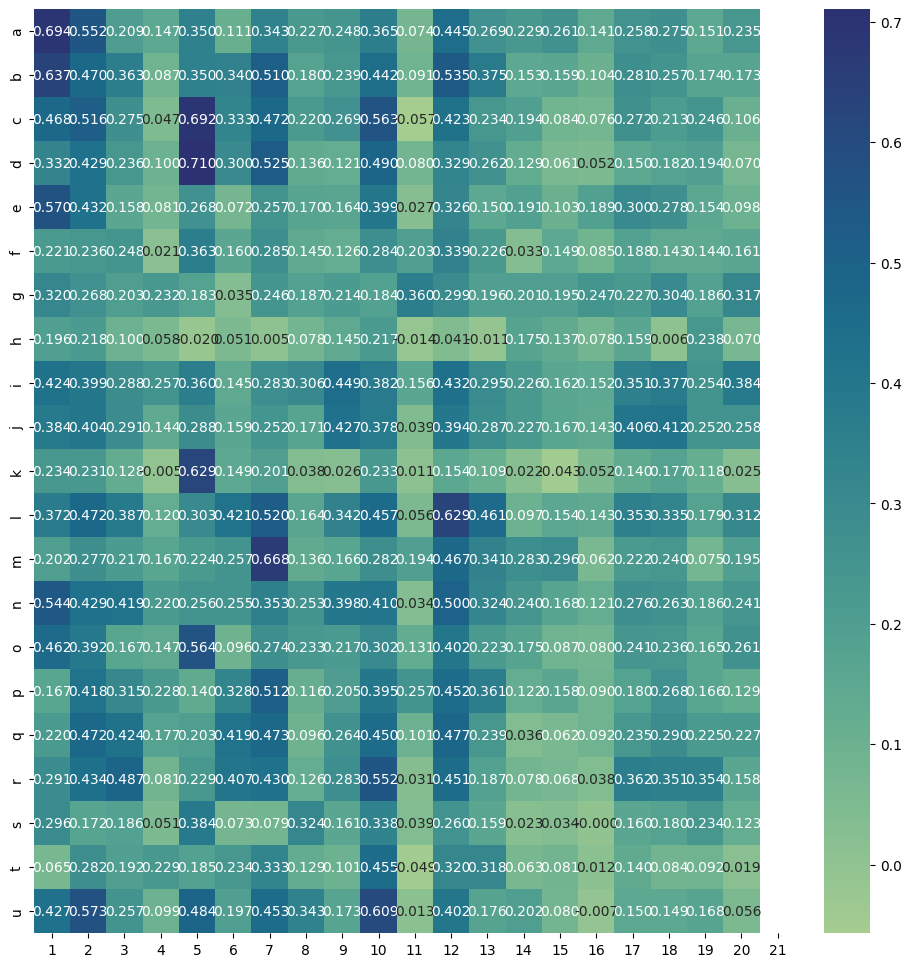

In [203]:
plot(result_df["matrix"].iloc[0])